In [1]:
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import sklearn as sk
import statsmodels.api as sm
import statsmodels.formula.api as smf
from math import sqrt
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Concatenate data from all subjects and all sessions
mycwd = os.getcwd()

path = r'/home/amoran/YASA/SWSdata/all_N3'
os.chdir(path)
all_files = glob.glob("*.csv")
df_from_each_file = (pd.read_csv(f) for f in all_files)
newdf =  []
for i, dff in enumerate(df_from_each_file):
    dff['Group']= all_files[i][0]
    dff['Subject'] = all_files[i][0:3]
    dff['Session'] = all_files[i][4]
    newdf.append(dff)

os.chdir(mycwd)

# Construct dataframe
concatenated_df = pd.concat(newdf, ignore_index=True)
concatenated_df.rename(columns={'Unnamed: 0':'Wave'}, inplace=True)
concatenated_df.loc[:,'Session'] = concatenated_df['Session'].astype(int)
concatenated_df.loc[:,'Start'] = concatenated_df['Start']/3600

# Name channels
chan_list = ['Fp1', 'Fpz', 'Fp2', 'AF7', 'AFz', 'AF8', 'F7', 'F3','Fz', 'F4', 'F8', 'FT7', 'FC3', 'FCz', 'FC4', 'FT8', 
             'A1', 'T7', 'C5', 'C3', 'Cz', 'C4', 'C6', 'T8', 'A2', 'TP7', 'CP3', 'CPz', 'CP4', 'TP8', 'P7', 'P3', 'Pz', 
             'P4', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2']
for i in range(len(chan_list)):
    concatenated_df.loc[(concatenated_df.Channel == 'EEG ' + chan_list[i]), 'Channel'] = chan_list[i]

# Add age
age = pd.read_csv('/home/amoran/YASA/SWSdata/NMDA-age.csv', usecols = ['Subject','Session','Birthdate','Testdate'])
age.loc[:,('Birthdate','Testdate')] = age.loc[:,('Birthdate','Testdate')].apply(pd.to_datetime)
age['Age'] = ((age['Testdate']-age['Birthdate']).apply(lambda r:r.days))/365.25
age['Age'] = round(age['Age'],2)
concatenated_df = concatenated_df.merge(age[['Subject','Session','Age']], on = ['Subject','Session'])


# Old/New system
concatenated_df['Machine'] = 'O'

subj1 = ['C22','C23','C21','C25','E17','E18','E20','E21','E22','E24','E25','E26','E27','S15','S16','S17','S18','S19','S20','S21','S22']
subj2 = ['E18','E20','E22']
subj3 = ['E13','E16','E17','E18']
subj4 = ['C13','C14','C15','C16','C20','C21','C23','E09','E10','E11','E13','E14','E15','E16','E18','S07','S08','S11','S12']
concatenated_df.loc[(concatenated_df['Session']==1)&concatenated_df.Subject.isin(subj1), 'Machine'] = 'N'
concatenated_df.loc[(concatenated_df['Session']==2)&concatenated_df.Subject.isin(subj2), 'Machine'] = 'N'
concatenated_df.loc[(concatenated_df['Session']==3)&concatenated_df.Subject.isin(subj3), 'Machine'] = 'N'
concatenated_df.loc[(concatenated_df['Session']==4)&concatenated_df.Subject.isin(subj4), 'Machine'] = 'N'


concatenated_df = concatenated_df.sort_values(by = ['Subject','Session','Start'])

In [3]:
concatenated_df

Wave     Start   NegPeak  MidCrossing   PosPeak       End  Duration  \
1921983  27805  0.414700   1493.21      1493.91   1494.21   1494.46      1.54   
1918817  24639  0.414703   1493.21      1493.93   1494.21   1494.45      1.52   
1919903  25725  0.414703   1493.21      1493.90   1494.20   1494.45      1.52   
1923017  28839  0.414708   1493.21      1493.90   1494.20   1494.45      1.50   
1909882  15704  0.511661   1842.21      1842.42   1842.64   1842.89      0.91   
...        ...       ...       ...          ...       ...       ...       ...   
1334957  46386  6.579250  23685.61     23685.98  23686.36  23686.71      1.41   
1332454  43883  6.579253  23685.64     23685.96  23686.25  23686.69      1.38   
1336717  48146  6.579253  23685.60     23685.88  23686.16  23686.76      1.45   
1335954  47383  6.579256  23685.60     23685.89  23686.18  23686.69      1.37   
1322241  33670  6.581536  23693.84     23694.07  23694.30  23694.57      1.04   

         ValNegPeak  ValPosPeak         PTP       Slope  Frequency  Stage  \
1921983  -65.334737   55.287266  120.622003  172.317148   0.649351      3   
1918817  -59.420787   51.588097  111.008883  154.179005   0.657895      3   
1919903  -51.825575   48.332985  100.158560  145.157333   0.657895      3   
1923017  -40.535248   41.188601   81.723849  118.440361   0.666667      3   
1909882  -40.794333   38.671684   79.466017  378.409606   1.098901      3   
...             ...         ...         ...         ...        ...    ...   
1334957  -60.315999   35.814551   96.130550  259.812298   0.709220      3   
1332454 -109.757843   66.807923  176.565765  551.768017   0.724638      3   
1336717  -57.528756   38.499313   96.028069  342.957389   0.689655      3   
1335954  -69.403295   47.462015  116.865310  402.983828   0.729927      3   
1322241  -40.027198   37.649891   77.677089  337.726473   0.961538      3   

        Channel  IdxChannel Group Subject Session    Age Machine  
1921983      Pz          32     C     C02       1  22.91       O  
1918817     CPz          27     C     C02       1  22.91       O  
1919903     CP4          28     C     C02       1  22.91       O  
1923017      P4          33     C     C02       1  22.91       O  
1909882     FCz          13     C     C02       1  22.91       O  
...         ...         ...   ...     ...     ...    ...     ...  
1334957     PO3          36     S     S22       1  18.30       N  
1332454      Pz          32     S     S22       1  18.30       N  
1336717     PO4          38     S     S22       1  18.30       N  
1335954     POz          37     S     S22       1  18.30       N  
1322241      Cz          20     S     S22       1  18.30       N  

[2925619 rows x 20 columns]

In [4]:
concatenated_df.to_pickle('./concatenated_dfn3_oct.pkl')
age.to_pickle('./age_oct.pkl')

In [5]:
# Subsets data
crs1 = concatenated_df['Session']==1
crs2 = concatenated_df['Session']==2
crs3 = concatenated_df['Session']==3
crs4 = concatenated_df['Session']==4

cri1 = concatenated_df['Group'] == 'C'
cri2 = concatenated_df['Group'] == 'E'
cri3 = concatenated_df['Group'] == 'S'
criC = cri1 & crs1
criE = cri2 & crs1
criS = cri3 & crs1

# Only data from session 1
data = concatenated_df[crs1]
# Add confusional arousals
cfsubj = ['E02','E03','E05','E06','E07','E16','E21','E22','C11','C12','C14','C18']
data['ConfArousal'] = 0
data.loc[concatenated_df.Subject.isin(cfsubj),'ConfArousal'] = 1
data.loc[:,'ConfArousal'] = data.loc[:,'ConfArousal'].astype('category')
# Data all groups sessions 1-4
data4 = concatenated_df[(crs1 | crs2 | crs3 | crs4)]
# Data encephalitis for 4 sessions
cridataE = cri1 & (crs1 | crs2 | crs3 | crs4)
dataE = concatenated_df[cridataE]

/tmp/ipykernel_2648058/2811139589.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ConfArousal'] = 0


In [6]:
# select frontal and posterior channels
chan_fp = ['Fp1', 'Fpz', 'Fp2', 'AF7', 'AFz', 'AF8', 'F7', 'F8', 'F3','Fz', 'F4', 'F8', 'P3', 'Pz', 'P4', 'PO7', 'PO3', 
           'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2']
data_fp = concatenated_df[concatenated_df.Channel.isin(chan_fp)]

# add column indicating whether frontal or posterior electrode
#chan_f = ['Fz','F3','F4']
chan_f = ['Fz','F3','F4','F7','F8']
data_fp['Position'] = 'P'
data_fp.loc[data_fp.Channel.isin(chan_f),'Position'] = 'F'
data_fp.loc[:,'Session'] = data_fp.loc[:,'Session'].astype(int)

/tmp/ipykernel_2648058/4165211598.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_fp['Position'] = 'P'


## Check age

In [7]:
age['Group'] = age['Subject'].str[0]
age.tail(9)

Subject  Session            Birthdate             Testdate    Age Group
127     E16        4  1961-05-23 00:00:00  2019-07-25 00:00:00  58.17     E
128     E18        4  1993-03-10 00:00:00  2020-02-27 00:00:00  26.97     E
129     S03        4  2000-04-13 00:00:00  2018-07-19 00:00:00  18.26     S
130     S05        4  1986-04-01 00:00:00  2019-11-08 00:00:00  33.60     S
131     S07        4  2002-06-21 00:00:00  2019-03-28 00:00:00  16.77     S
132     S08        4  2003-05-09 00:00:00  2019-03-27 00:00:00  15.88     S
133     S11        4  2003-05-15 00:00:00  2019-11-07 00:00:00  16.48     S
134     S12        4  1998-03-04 00:00:00  2019-09-05 00:00:00  21.51     S
135     S15        4  2000-06-18 00:00:00  2020-02-20 00:00:00  19.67     S

average age: 26.050588235294118
average age controls: 25.523043478260874
average age encephalitis: 28.807199999999998
average age schizophrenia: 23.2115


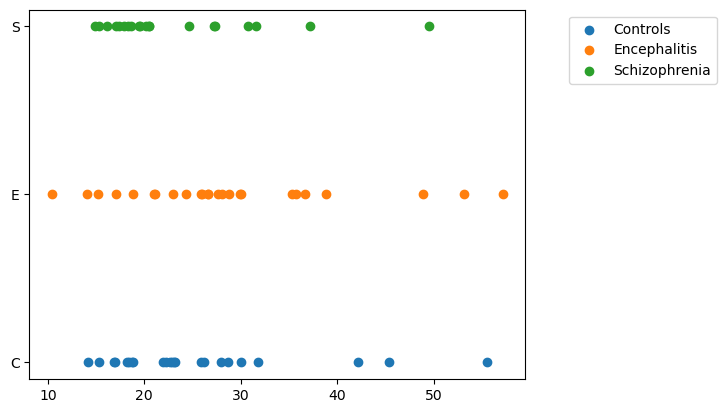

In [8]:
# Session 1
print('average age:', np.mean(age.loc[age['Session']==1, 'Age']))
print('average age controls:', np.mean(age.loc[((age['Group']=='C')&(age['Session']==1)), 'Age']))
print('average age encephalitis:', np.mean(age.loc[((age['Group']=='E')&(age['Session']==1)), 'Age']))
print('average age schizophrenia:', np.mean(age.loc[((age['Group']=='S')&(age['Session']==1)), 'Age']))

# plot age
plt.scatter(age.loc[((age['Group']=='C')&(age['Session']==1)), 'Age'], age.loc[((age['Group']=='C')&(age['Session']==1)), 'Group'], label = 'Controls')
plt.scatter(age.loc[((age['Group']=='E')&(age['Session']==1)), 'Age'], age.loc[((age['Group']=='E')&(age['Session']==1)), 'Group'], label = 'Encephalitis')
plt.scatter(age.loc[((age['Group']=='S')&(age['Session']==1)), 'Age'], age.loc[((age['Group']=='S')&(age['Session']==1)), 'Group'], label = 'Schizophrenia')
plt.legend(bbox_to_anchor=(1.4, 1.0))
plt.show()

## Individual plots

In [9]:
data_F = data_fp.copy()
data_F = data_F[data_F['Position'] == 'F'].reset_index(drop=True)
data_F.head()

Wave     Start  NegPeak  MidCrossing  PosPeak      End  Duration  \
0   9498  0.673000  2423.08      2423.34  2423.57  2423.91      1.11   
1   8491  0.679381  2446.06      2446.33  2446.52  2447.30      1.53   
2  10707  0.679381  2446.04      2446.28  2446.48  2446.75      0.98   
3  11960  0.679381  2446.03      2446.27  2446.47  2446.75      0.98   
4  13134  0.679381  2446.02      2446.25  2446.47  2446.79      1.02   

   ValNegPeak  ValPosPeak         PTP  ...  Frequency  Stage  Channel  \
0  -46.707747   32.177395   78.885141  ...   0.900901      3       F3   
1  -89.754462   38.805616  128.560078  ...   0.653595      3       F7   
2 -117.820316   70.414380  188.234695  ...   1.020408      3       Fz   
3 -111.116778   73.118567  184.235346  ...   1.020408      3       F4   
4  -55.017271   42.728858   97.746129  ...   0.980392      3       F8   

  IdxChannel  Group Subject Session    Age  Machine Position  
0          7      C     C02       1  22.91        O        F  
1          6      C     C02       1  22.91        O        F  
2          8      C     C02       1  22.91        O        F  
3          9      C     C02       1  22.91        O        F  
4         10      C     C02       1  22.91        O        F  

[5 rows x 21 columns]

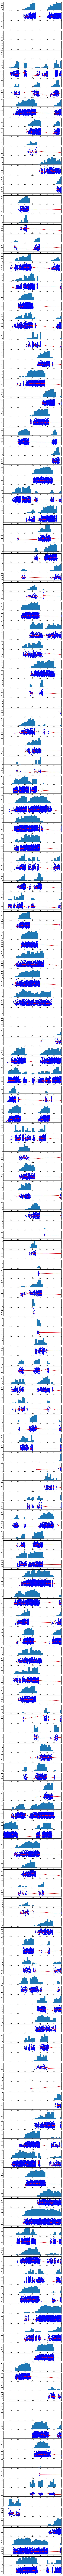

In [13]:
data_F['Id'] = data_F['Subject'] + '_' + data_F['Session'].astype(str)

num_subplots = len(data_F['Id'].unique())

# Create a figure and subplots
fig, axs = plt.subplots(2*num_subplots, 1, figsize=(12, 4*num_subplots), gridspec_kw={'hspace': 0.25})

c = 0
for idx, (name, Subject) in enumerate(data_F.groupby('Id')):
    Subject = Subject.sort_values(by=['Start']).reset_index(drop=True)
    Subject['Time'] = pd.to_datetime(Subject['Start'],unit = 'h')
    Subject = Subject.set_index('Time')
    rmean = Subject.Slope.rolling('60s').mean()

    axs[idx + c].set_title(name)
    binBoundaries = np.arange(0,10,0.05)
    axs[idx + c].hist(Subject['Start'],bins=binBoundaries)
    axs[idx + c].set_xlim([0, 2])

    c = c + 1

    axs[idx + c].scatter(Subject['Start'],Subject['Slope'],color='blue')
    x, mean = zip(*sorted(zip(Subject['Start'], rmean),key=lambda x: x[0]))
    axs[idx + c].plot(x, mean, color='red')
    axs[idx + c].set_xlim([0, 2])



    

    

In [ ]:
dataC11 = data[data['Subject']=='C11'].sort_values(by=['Start']).reset_index(drop=True)
dataC11['Time'] = pd.to_datetime(dataC11['Start'],unit = 'h')
dataC11 = dataC11.set_index('Time')
dataC11

Wave     Start   NegPeak  MidCrossing   PosPeak  \
Time                                                                        
1970-01-01 00:31:08.630  13458  0.519064   1868.93      1869.19   1869.33   
1970-01-01 00:31:08.690   1942  0.519081   1868.98      1869.21   1869.42   
1970-01-01 00:31:10.060   8812  0.519461   1870.37      1870.69   1871.25   
1970-01-01 00:31:10.160  13459  0.519489   1870.36      1870.54   1870.75   
1970-01-01 00:31:10.170   6784  0.519492   1870.38      1870.59   1870.79   
...                        ...       ...       ...          ...       ...   
1970-01-01 03:43:57.860  32016  3.732739  13438.35     13438.74  13439.08   
1970-01-01 03:43:57.900  34326  3.732750  13438.30     13438.74  13439.13   
1970-01-01 03:43:57.950  36054  3.732764  13438.31     13438.82  13439.23   
1970-01-01 03:43:58.250  15418  3.732847  13438.54     13438.76  13439.02   
1970-01-01 03:43:58.310   8811  3.732864  13438.56     13438.76  13438.98   

                              End  Duration  ValNegPeak  ValPosPeak  \
Time                                                                  
1970-01-01 00:31:08.630   1869.50      0.87  -57.416745   21.071738   
1970-01-01 00:31:08.690   1870.14      1.45  -46.870498   34.325107   
1970-01-01 00:31:10.060   1871.48      1.42  -64.600673   51.955843   
1970-01-01 00:31:10.160   1871.01      0.85  -45.328099   47.774554   
1970-01-01 00:31:10.170   1871.53      1.36  -45.581761   30.905024   
...                           ...       ...         ...         ...   
1970-01-01 03:43:57.860  13439.33      1.47  -47.244953   48.938904   
1970-01-01 03:43:57.900  13439.38      1.48  -50.245239   48.156141   
1970-01-01 03:43:57.950  13439.52      1.57  -51.886602   39.566137   
1970-01-01 03:43:58.250  13439.27      1.02  -45.172223   51.261979   
1970-01-01 03:43:58.310  13439.18      0.87  -42.572207   44.745692   

                                PTP  ...  Stage  Channel  IdxChannel Group  \
Time                                 ...                                     
1970-01-01 00:31:08.630   78.488483  ...      3       Fz           8     C   
1970-01-01 00:31:08.690   81.195605  ...      3      Fpz           1     C   
1970-01-01 00:31:10.060  116.556516  ...      3      AF8           5     C   
1970-01-01 00:31:10.160   93.102653  ...      3       Fz           8     C   
1970-01-01 00:31:10.170   76.486785  ...      3      AFz           4     C   
...                             ...  ...    ...      ...         ...   ...   
1970-01-01 03:43:57.860   96.183856  ...      3      CP4          28     C   
1970-01-01 03:43:57.900   98.401379  ...      3       P4          33     C   
1970-01-01 03:43:57.950   91.452739  ...      3      PO4          38     C   
1970-01-01 03:43:58.250   96.434202  ...      3       Fz           8     C   
1970-01-01 03:43:58.310   87.317899  ...      3      AFz           4     C   

                         Subject Session    Age Machine  ConfArousal     Id  
Time                                                                         
1970-01-01 00:31:08.630      C11       1  16.88       O            1  C11_1  
1970-01-01 00:31:08.690      C11       1  16.88       O            1  C11_1  
1970-01-01 00:31:10.060      C11       1  16.88       O            1  C11_1  
1970-01-01 00:31:10.160      C11       1  16.88       O            1  C11_1  
1970-01-01 00:31:10.170      C11       1  16.88       O            1  C11_1  
...                          ...     ...    ...     ...          ...    ...  
1970-01-01 03:43:57.860      C11       1  16.88       O            1  C11_1  
1970-01-01 03:43:57.900      C11       1  16.88       O            1  C11_1  
1970-01-01 03:43:57.950      C11       1  16.88       O            1  C11_1  
1970-01-01 03:43:58.250      C11       1  16.88       O            1  C11_1  
1970-01-01 03:43:58.310      C11       1  16.88       O            1  C11_1  

[36910 rows x 22 columns]

In [ ]:
dataC11.Slope.rolling('1000s').mean()

Time
1970-01-01 00:31:08.630    301.878780
1970-01-01 00:31:08.690    327.451575
1970-01-01 00:31:10.060    339.714088
1970-01-01 00:31:10.160    384.094806
1970-01-01 00:31:10.170    380.120402
                              ...    
1970-01-01 03:43:57.860    512.359581
1970-01-01 03:43:57.900    512.329930
1970-01-01 03:43:57.950    512.295733
1970-01-01 03:43:58.250    512.326163
1970-01-01 03:43:58.310    512.318385
Name: Slope, Length: 36910, dtype: float64

<Figure size 2500x500 with 0 Axes>

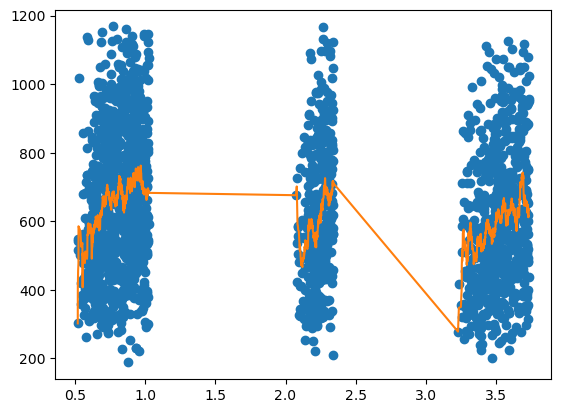

<Figure size 2500x500 with 0 Axes>

In [ ]:
dataC11Fz = dataC11[dataC11['Channel'] == 'Fz']
rmean1Fz = dataC11Fz.Slope.rolling('100s').mean()
plt.scatter(dataC11Fz['Start'], dataC11Fz['Slope'])
x, mean = zip(*sorted(zip(dataC11Fz['Start'], rmean1Fz),key=lambda x: x[0]))
plt.plot(x, mean, color='C1')
plt.figure(figsize=(25,5))


<Figure size 2500x500 with 0 Axes>

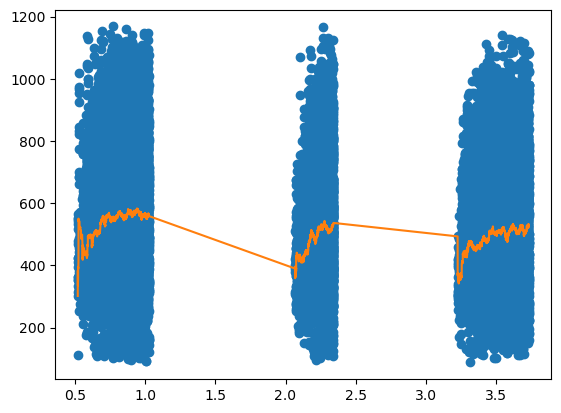

<Figure size 2500x500 with 0 Axes>

In [ ]:
rmean1 = dataC11.Slope.rolling('100s').mean()
plt.scatter(dataC11['Start'], dataC11['Slope'])
x, mean = zip(*sorted(zip(dataC11['Start'], rmean1),key=lambda x: x[0]))
plt.plot(x, mean, color='C1')
plt.figure(figsize=(25,5))

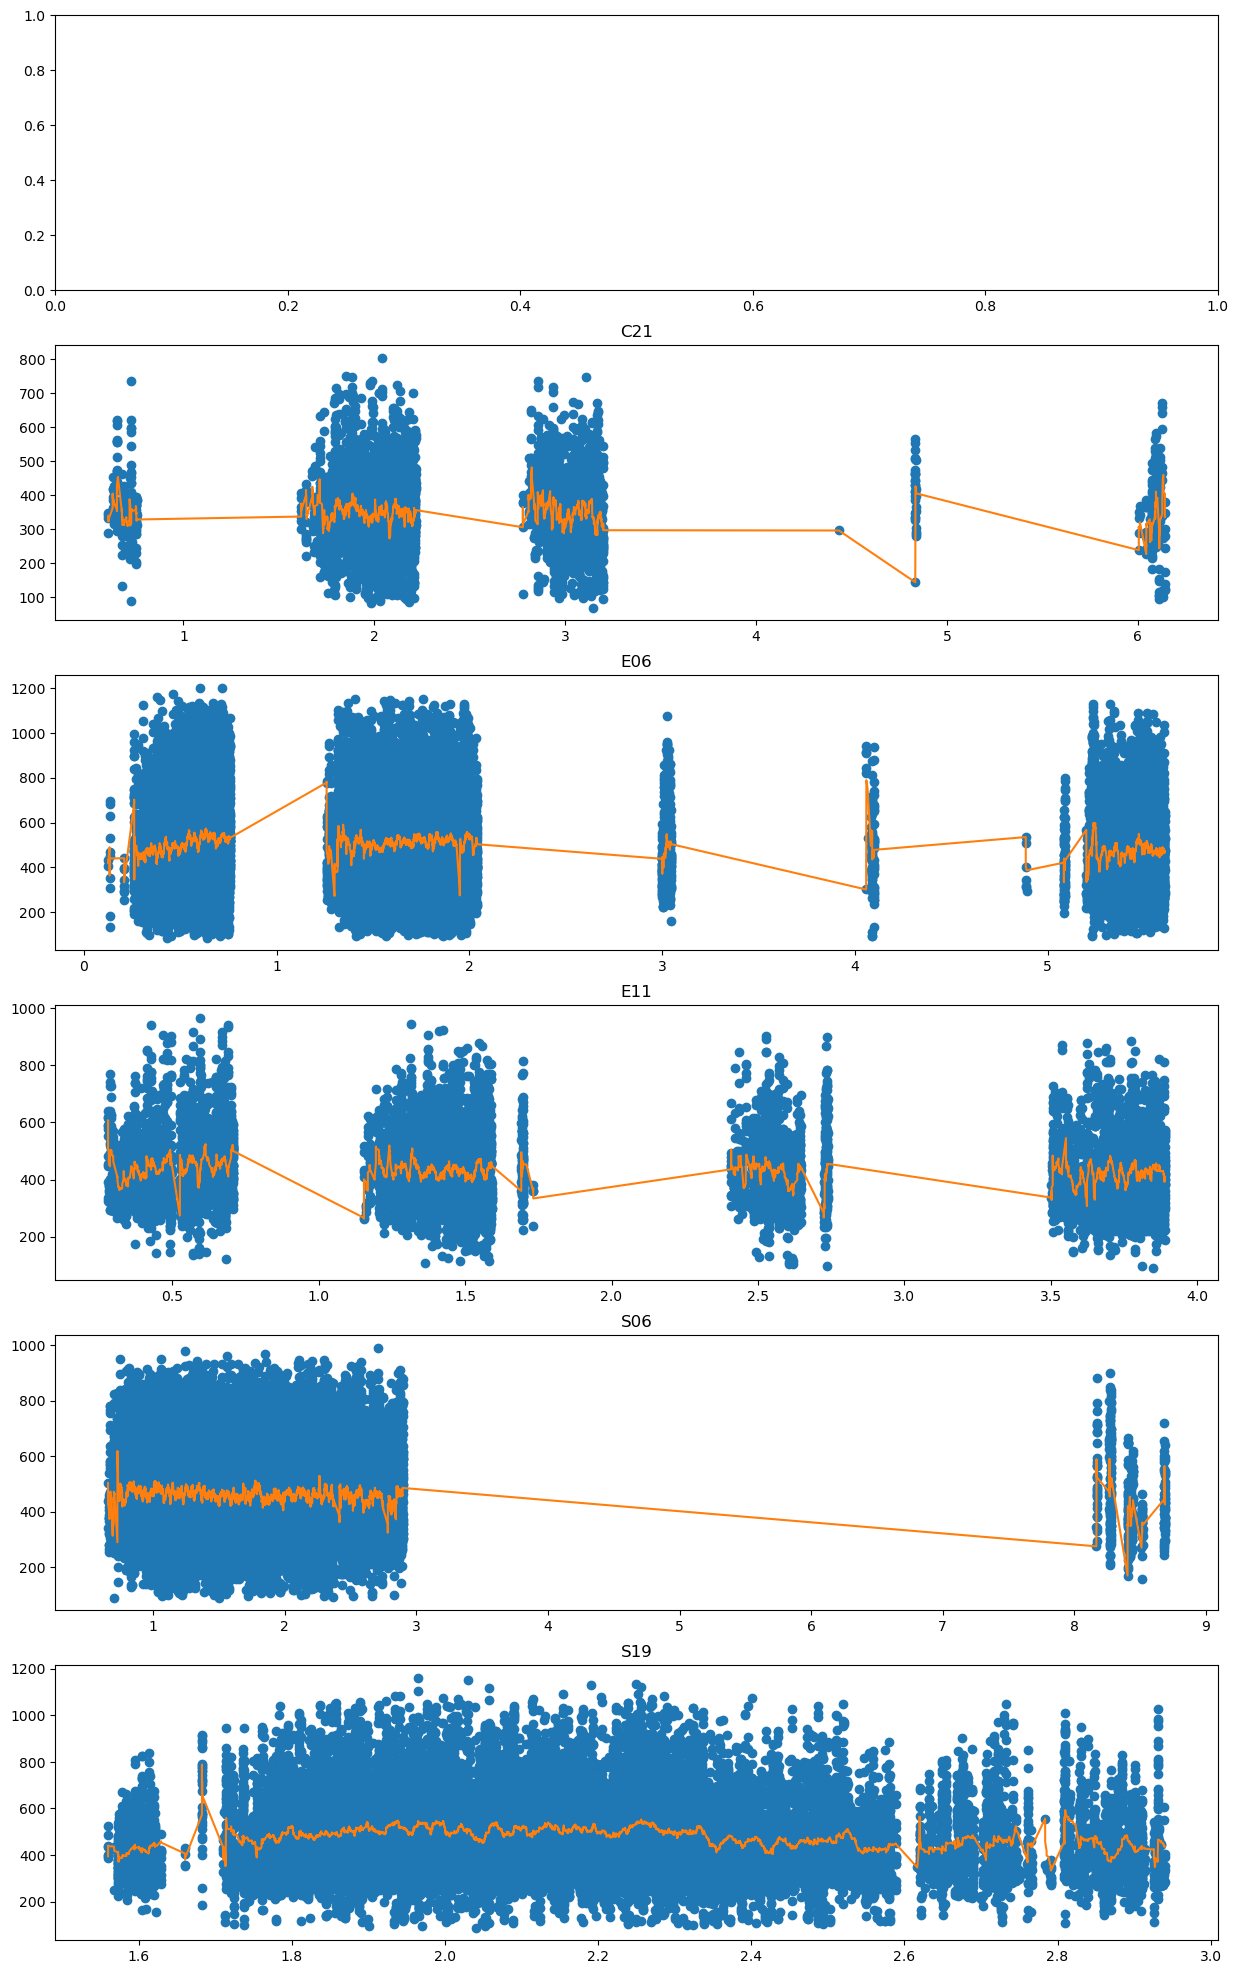

In [ ]:
fig, ax = plt.subplots(6, 1, figsize = (15, 25))

### DATA
#dataC11 = data[data['Subject']=='C11'].sort_values(by=['Start']).reset_index(drop=True)
#dataC11['Time'] = pd.to_datetime(dataC11['Start'],unit = 'h')
#dataC11 = dataC11.set_index('Time')
#rmean1 = dataC11.Slope.rolling('60s').mean()
dataC21 = data[data['Subject']=='C21'].sort_values(by=['Start']).reset_index(drop=True)
dataC21['Time'] = pd.to_datetime(dataC21['Start'],unit = 'h')
dataC21 = dataC21.set_index('Time')
rmean2 = dataC21.Slope.rolling('60s').mean()
dataE06 = data[data['Subject']=='E06'].sort_values(by=['Start']).reset_index(drop=True)
dataE06['Time'] = pd.to_datetime(dataE06['Start'],unit = 'h')
dataE06 = dataE06.set_index('Time')
rmean3 = dataE06.Slope.rolling('60s').mean()
dataE11 = data[data['Subject']=='E11'].sort_values(by=['Start']).reset_index(drop=True)
dataE11['Time'] = pd.to_datetime(dataE11['Start'],unit = 'h')
dataE11 = dataE11.set_index('Time')
rmean4 = dataE11.Slope.rolling('60s').mean()
dataS06 = data[data['Subject']=='S06'].sort_values(by=['Start']).reset_index(drop=True)
dataS06['Time'] = pd.to_datetime(dataS06['Start'],unit = 'h')
dataS06 = dataS06.set_index('Time')
rmean5 = dataS06.Slope.rolling('60s').mean()
dataS19 = data[data['Subject']=='S19'].sort_values(by=['Start']).reset_index(drop=True)
dataS19['Time'] = pd.to_datetime(dataS19['Start'],unit = 'h')
dataS19 = dataS19.set_index('Time')
rmean6 = dataS19.Slope.rolling('60s').mean()

# Plot individuals with running mean
#ax[0].set_title('C11')
#ax[0].scatter(dataC11['Start'], dataC11['Slope'])
#x, mean = zip(*sorted(zip(dataC11['Start'], rmean1),key=lambda x: x[0]))
#ax[0].plot(x, mean, color='C1')

ax[1].set_title('C21')
ax[1].scatter(dataC21['Start'], dataC21['Slope'])
x, mean = zip(*sorted(zip(dataC21['Start'], rmean2),key=lambda x: x[0]))
ax[1].plot(x, mean, color='C1')

ax[2].set_title('E06')
ax[2].scatter(dataE06['Start'], dataE06['Slope'])
x, mean = zip(*sorted(zip(dataE06['Start'], rmean3),key=lambda x: x[0]))
ax[2].plot(x, mean, color='C1')

ax[3].set_title('E11')
ax[3].scatter(dataE11['Start'], dataE11['Slope'])
x, mean = zip(*sorted(zip(dataE11['Start'], rmean4),key=lambda x: x[0]))
ax[3].plot(x, mean, color='C1')

ax[4].set_title('S06')
ax[4].scatter(dataS06['Start'], dataS06['Slope'])
x, mean = zip(*sorted(zip(dataS06['Start'], rmean5),key=lambda x: x[0]))
ax[4].plot(x, mean, color='C1')

ax[5].set_title('S19')
ax[5].scatter(dataS19['Start'], dataS19['Slope'])
x, mean = zip(*sorted(zip(dataS19['Start'], rmean6),key=lambda x: x[0]))
ax[5].plot(x, mean, color='C1')